##### **Clinopyroxene and clinopyroxene-liquid thermo-barometers**

This script applies pre-trained models to your data set and it gives you back pressure or temperature estimates of your samples in kbar and °C, respectively.
What do you need to do?
1. You just need to replace the values of the oxides you find in the "Unknowns-template.xlsx" (in the datasets folder) with your own measurements. Do not change the name of the file or the name of the columns!
2. Select between 'cpx_only' or 'cpx_liquid' and  'Temperature' or 'Pressure' on the next cell.
3. Press the "restart the kernel and run all cells" button to get your results! Your results will be in an Excel file in the "out-files" folder.
- Note: To specify your own errors, go to part '5.Monte carlo error propagation' and follow the instructions bellow. The user is responsible for the pre-processing step of their own data,  e.g., filtering, equilibrium tests, etc.

# Settings

In [11]:
model = 'cpx_only' # 'cpx_only' or 'cpx_liquid'
output = 'Temperature' # 'Temperature' or 'Pressure'
p = 1000  #Number of replicates in the Monte-Carlo simulation-putting a low number will result in an incorrect estimation of the error.


# Import

In [12]:
import numpy as np
import pandas as pd
import json
import onnxruntime as rt
import scipy.stats as st
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as RMSE
from ML_PT_Pyworkflow import*

import warnings
warnings.filterwarnings('ignore')

# Data Loading

Available datasets: 
- "Jorgenson": dataset used for training and testing.
- "Train_P": training dataset for pressure cpx and cpx_liquid models
- "Train_T": training dataset for temperature cpx and cpx_liquid models.
- "ArcPl": External test, Filtered ArcPl compilation, original data from: __[Wieser et al.(2023)](https://doi.org/10.1093/petrology/egac126)__ .
- "Test_P": Internal test (20 % of original dataset) used to evaluate pressure estimates using cpx and cpx_liquid models.
- "Test_T": Internal test (20 % of original dataset) used to evaluate temperature estimates using cpx and cpx_liquid models.
- "Unknowns": The user unknowns.

In [13]:
#df_init = Dataset.Test_P
df_init = Dataset.Unknowns
df  = data_imputation(df_init)

Elements_Cpx = ['SiO2_Cpx', 'TiO2_Cpx', 'Al2O3_Cpx', 'FeOt_Cpx', 'MgO_Cpx', 'MnO_Cpx', 'CaO_Cpx',  'Na2O_Cpx', 'Cr2O3_Cpx']
Elements_Liq = ['SiO2_Liq', 'TiO2_Liq', 'Al2O3_Liq', 'FeOt_Liq', 'MgO_Liq', 'MnO_Liq', 'CaO_Liq',  'Na2O_Liq', 'K2O_Liq']

if model == 'cpx_only':
    for element in Elements_Cpx:
        df_m = replace_zeros(df, element)
    sample_names = df['Sample_ID'] 
    Xd = df[Elements_Cpx]
    X = np.array(Xd)
        
elif model == 'cpx_liquid':
    for element in Elements_Cpx:
        df_m = replace_zeros(df, element) 
    for element in Elements_Liq:
        df_m = replace_zeros(df, element)
    sample_names = df['Sample_ID'] 
    Xd = df[Elements_Cpx+Elements_Liq]
    X = np.array(Xd)

## Training bounds

In [14]:
if model == 'cpx_only' and output == 'Pressure':
    pred_max_bound = np.ones(len(X)) * 30.000000
    pred_min_bound = np.ones(len(X)) * 0.00000
    warning = df.apply(lambda x: '' if 0.250000<=x['Al2O3_Cpx']<=25.760000
                                      and 0.000137<=x['Na2O_Cpx']<=7.760000
                                      and 0.400000<=x['CaO_Cpx']<=24.820000
                                    else 'Input out of bound', axis=1) 
elif model == 'cpx_liquid' and output == 'Pressure':
    pred_max_bound = np.ones(len(X)) * 30.000000
    pred_min_bound = np.ones(len(X)) * 0.00000
    warning = df.apply(lambda x: '' if 0.250000<=x['Al2O3_Cpx']<=25.760000
                                      and 0.000137<=x['Na2O_Cpx']<=7.760000
                                      and 0.030000<=x['MgO_Liq']<=18.587513
                                    else 'Input out of bound', axis=1) 
elif model == 'cpx_only' and output == 'Temperature':
    pred_max_bound = np.ones(len(X)) * 1700.000000
    pred_min_bound = np.ones(len(X)) * 700.000000
    warning = df.apply(lambda x: '' if 0.760000<=x['MgO_Cpx']<=31.300000
                                      and 0.400000<=x['CaO_Cpx']<=24.820000
                                      and 0.290000<=x['Al2O3_Cpx']<=19.010000
                                      and 1.700000<=x['FeOt_Cpx']<=34.200000
                                      and 0.000179<=x['MnO_Cpx']<=2.980000
                                    else 'Input out of bound', axis=1)
elif model == 'cpx_liquid' and output == 'Temperature':
    pred_max_bound = np.ones(len(X)) * 1700.000000
    pred_min_bound = np.ones(len(X)) * 700.000000
    warning = df.apply(lambda x: '' if 0.030000<=x['MgO_Liq']<=17.723561
                                    else 'Input out of bound', axis=1)

# Monte Carlo error propagation

In [15]:
std_dev_perc = Parameters.oxide_rel_err 
K = Parameters.K_rel_err

if model == 'cpx_only':
    std_dev_perc = std_dev_perc
            
elif model == 'cpx_liquid':
    std_dev_perc_temp_1 = std_dev_perc
    std_dev_perc_temp_2 = std_dev_perc[:-1]
    std_dev_perc = np.concatenate((std_dev_perc_temp_1,std_dev_perc_temp_2,K),axis=None)

To specify different errors for each observation, you can upload an Excel file using the cell below (uncomment the lines). The structure of the Excel file needs to have the same size of your input file and the name of the columns must be the following: 

- cpx_only: 'SiO2_Cpx', 'TiO2_Cpx', 'Al2O3_Cpx', 'FeOt_Cpx', 'MgO_Cpx', 'MnO_Cpx', 'CaO_Cpx',  'Na2O_Cpx', 'Cr2O3_Cpx'
- Cpx_liquid: 'SiO2_Cpx', 'TiO2_Cpx', 'Al2O3_Cpx', 'FeOt_Cpx', 'MgO_Cpx', 'MnO_Cpx', 'CaO_Cpx',  'Na2O_Cpx', 'Cr2O3_Cpx','SiO2_Liq', 'TiO2_Liq', 'Al2O3_Liq', 'FeOt_Liq', 'MgO_Liq', 'MnO_Liq', 'CaO_Liq',  'Na2O_Liq', 'K2O_Liq' 


In [16]:
if model == "cpx_only":
    Elements_std = ['SiO2_Cpx_rel_err', 'TiO2_Cpx_rel_err', 'Al2O3_Cpx_rel_err', 'FeOt_Cpx_rel_err', 'MgO_Cpx_rel_err', 'MnO_Cpx_rel_err', 'CaO_Cpx_rel_err',
                    'Na2O_Cpx_rel_err', 'Cr2O3_Cpx_rel_err']
elif model == "cpx_liquid":
    Elements_std = ['SiO2_Cpx_rel_err', 'TiO2_Cpx_rel_err', 'Al2O3_Cpx_rel_err', 'FeOt_Cpx_rel_err', 'MgO_Cpx_rel_err', 'MnO_Cpx_rel_err', 'CaO_Cpx_rel_err',
                'Na2O_Cpx_rel_err', 'Cr2O3_Cpx_rel_err', 'SiO2_Liq_rel_err', 'TiO2_Liq_rel_err', 'Al2O3_Liq_rel_err', 'FeOt_Liq_rel_err', 'MgO_Liq_rel_err',
                'MnO_Liq_rel_err', 'CaO_Liq_rel_err',  'Na2O_Liq_rel_err', 'K2O_Liq_rel_err']
    
df_std_dev_perc = pd.read_excel('./datasets/Unknowns-template.xlsx', usecols=Elements_std)

if len(df_std_dev_perc) != len(X) or len(df_std_dev_perc.columns) != np.shape(X)[1]:
    print("Input dataset and standard deviation have different sizes. We are using the default relative errors for all observations.")
else:
    std_dev_perc = np.array(df_std_dev_perc)


In [17]:
X_perturb, groups = input_perturbation(X,std_dev_perc ,n_perturbations=p)

# Model Prediction

In [18]:
scaler, predictor, bias_json = P_T_predictors(output, model)
X_perturb_s = scaler.transform(X_perturb)

bias_popt_left = np.array(bias_json['slope']['left'])
bias_popt_right = np.array(bias_json['slope']['right'])
ang_left = bias_json['angle']['left']
ang_right = bias_json['angle']['right']

input_name = predictor.get_inputs()[0].name  
label_name = predictor.get_outputs()[0].name 
y_pred = predictor.run([label_name],{input_name: X_perturb_s.astype(np.float32)})[0]


In [19]:
unit = 'kbar' if output == 'Pressure' else 'C'
    
unique_y_pred = np.apply_along_axis(np.median,1, np.split(y_pred[:,0],len(y_pred)/p))
unique_y_perc_max = np.apply_along_axis(max_perc,1, np.split(y_pred[:,0],len(y_pred)/p))
unique_y_perc_min = np.apply_along_axis(min_perc,1, np.split(y_pred[:,0],len(y_pred)/p))

bias_temp = bias_f(unique_y_pred,
                   ang_left, bias_popt_left, 
                   ang_right, bias_popt_right)


unique_y_pred_temp = unique_y_pred - bias_temp
unique_y_perc_max_temp = unique_y_perc_max - bias_temp
unique_y_perc_min_temp =  unique_y_perc_min - bias_temp

# Bound of the training set 
unique_y_pred = np.minimum(pred_max_bound, np.maximum(pred_min_bound, unique_y_pred_temp))
unique_y_perc_max = np.minimum(pred_max_bound, np.maximum(pred_min_bound, unique_y_perc_max_temp))
unique_y_perc_min = np.minimum(pred_max_bound, np.maximum(pred_min_bound, unique_y_perc_min_temp))


error = (unique_y_perc_max - unique_y_perc_min)/2
predictions = pd.DataFrame(data=np.transpose(np.array([unique_y_pred,unique_y_perc_max,unique_y_perc_min])),    
             columns=[output+'_'+unit, 'Percentile_84', 'Percentile_16']) 
predictions['warning'] = warning

print('Predictions:')
print(predictions)

df_orig = df_init
df_orig['Sample_ID'] = df_orig['Sample_ID'].astype(str)

if model == 'cpx_only':
    df_orig = pd.concat([df_orig['Sample_ID'], df_orig[Elements_Cpx]], axis=1)
    output_file_name = 'out-files/Results_cpx_only_' + output + '.xlsx'
    
elif model == 'cpx_liquid':
    df_orig = pd.concat([df_orig['Sample_ID'], df_orig[Elements_Cpx + Elements_Liq]], axis=1)
    output_file_name = 'out-files/Results_cpx_liquid_' + output + '.xlsx'
    
finaldf = pd.concat([df_orig, predictions], axis=1)    
print(finaldf.head())


print(finaldf.head())
finaldf.to_excel(output_file_name, sheet_name=output, index=False)


Predictions:
     Temperature_C  Percentile_84  Percentile_16 warning
0      1120.008301    1121.540308    1118.460752        
1      1115.352051    1118.213115    1113.177739        
2      1138.407471    1139.750361    1137.151206        
3      1043.458008    1049.662437    1036.965645        
4      1148.217773    1149.997573    1145.348218        
..             ...            ...            ...     ...
338    1082.683960    1091.525166    1072.807393        
339    1125.327881    1127.849766    1123.256631        
340    1126.558105    1128.652920    1124.897808        
341    1122.005737    1124.139541    1120.184600        
342    1127.852539    1129.337607    1125.687788        

[343 rows x 4 columns]
          Sample_ID   SiO2_Cpx  TiO2_Cpx  Al2O3_Cpx  FeOt_Cpx    MgO_Cpx  \
0   Fe15-07_Cpx_1_1  50.344551    1.8800       5.55      7.48  14.595529   
1   Fe15-07_Cpx_1_2  49.106571    1.9700       4.74      7.85  14.723560   
2   Fe15-07_Cpx_1_3  48.714040    2.0200       5.08

# Data Visualization

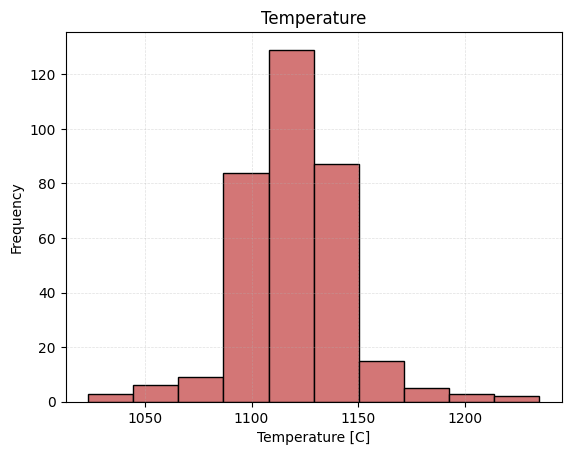

In [20]:
# Plot histogram
My_color = '#9BB0C1' if output == 'Pressure' else '#D37676'
plt.hist(finaldf[output+'_'+unit], color=My_color, edgecolor='black')
plt.xlabel(output+' ['+unit+']')
plt.ylabel('Frequency')
plt.title(output)
plt.grid(color='#B2B2B2', linestyle='--', linewidth=0.5, alpha=0.4)
plt.savefig('Figures/'+'Results_'+output+ ('_cpx' if model== 'cpx_only' else '_cpx_liq') +'.pdf', format='pdf')
